In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

In [3]:
train_set = pd.read_csv("./Data/train.csv")
test_set = pd.read_csv("./Data/test.csv")

In [4]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Explorative Data Analysis

In [8]:
unique_ticket_values = train_set["Ticket"].nunique()
unique_fare_values = train_set["Fare"].nunique()
unique_cabin_values = train_set["Cabin"].nunique()
unique_embarked_values = train_set["Embarked"].nunique()

print(f"Unique Ticket Values: {unique_ticket_values}")
print(f"Unique Fare Values: {unique_fare_values}")
print(f"Unique Cabin Values: {unique_cabin_values}")
print(f"Unique Embarked Values: {unique_embarked_values}")

Unique Ticket Values: 681
Unique Fare Values: 248
Unique Cabin Values: 147
Unique Embarked Values: 3


In [9]:
# Test whether names from train occur in test --> only 2 occurences so the Name column will be neglected
multiple_name_occurences = pd.merge(train_set, test_set, how="inner", on="Name")
multiple_name_occurences.head()

,PassengerId_x,Survived,Pclass_x,Name,Sex_x,Age_x,SibSp_x,Parch_x,Ticket_x,Fare_x,...,PassengerId_y,Pclass_y,Sex_y,Age_y,SibSp_y,Parch_y,Ticket_y,Fare_y,Cabin_y,Embarked_y
0,290,1,3,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.75,...,898,3,female,30.0,0,0,330972,7.6292,NaN,Q
1,697,0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.05,...,892,3,male,34.5,0,0,330911,7.8292,NaN,Q


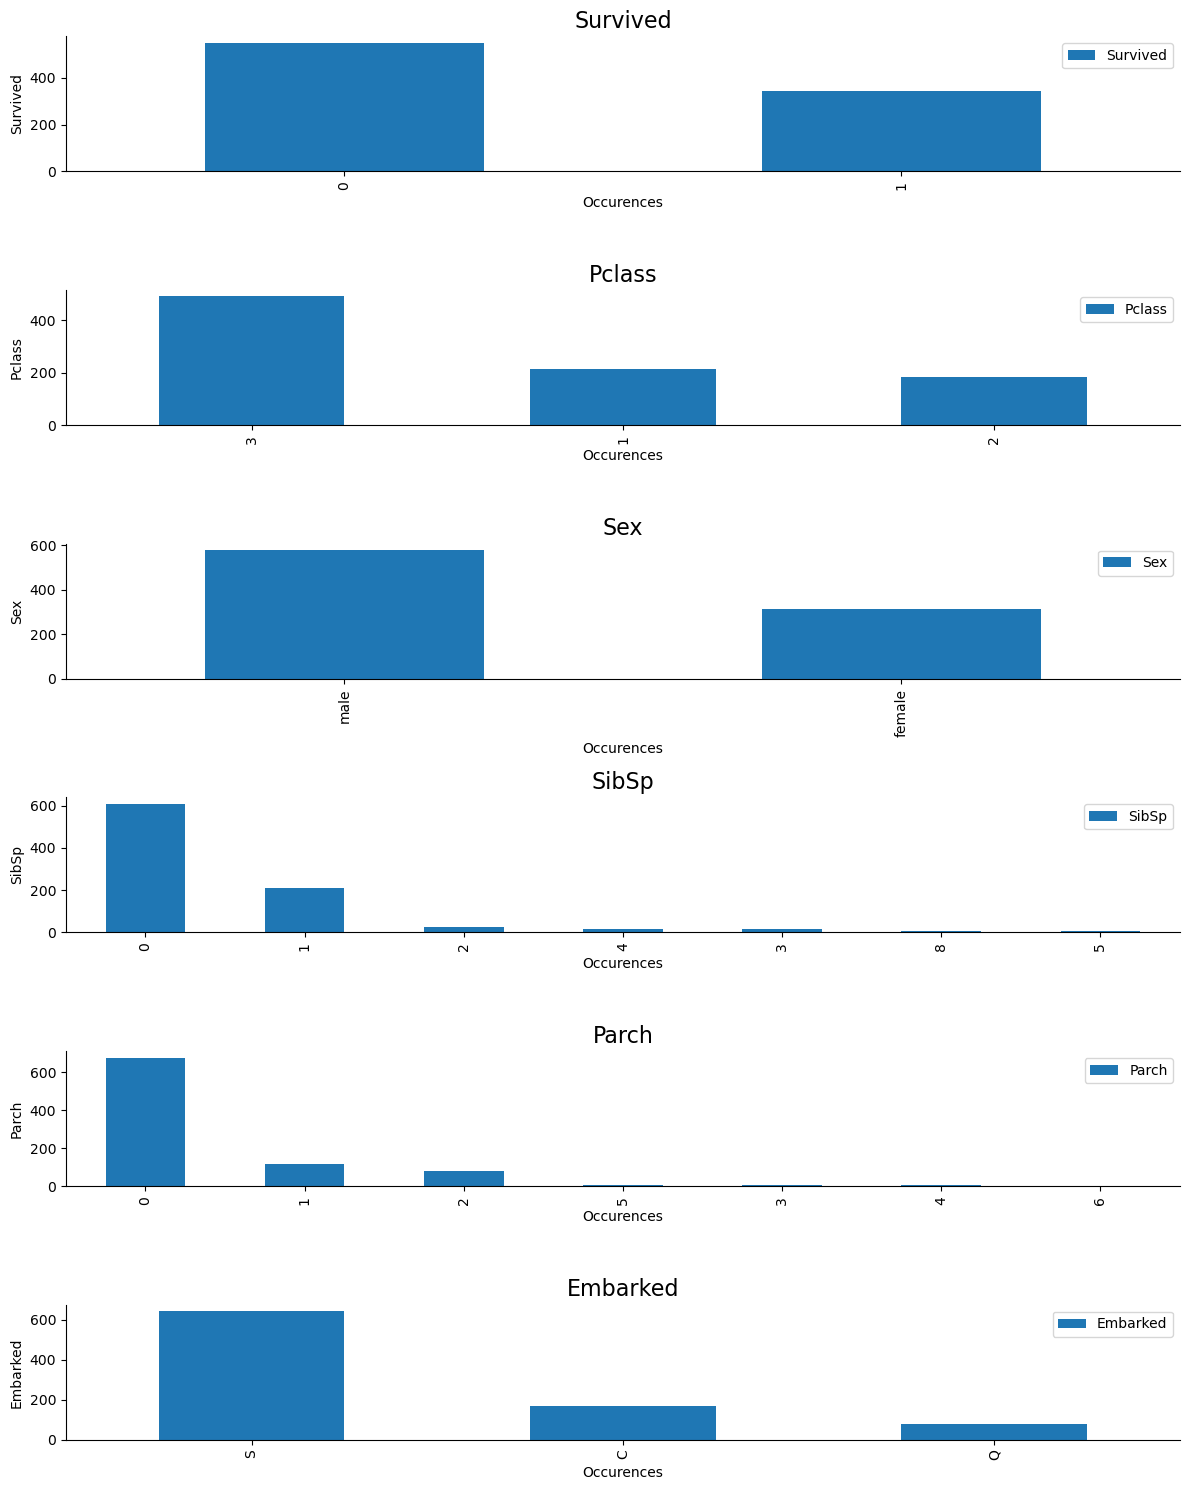

In [19]:
# This code plots columns in a dataframe.

# Interesting Columns
columns_to_visualize = ["Survived", "Pclass", "Sex", "SibSp", "Parch", "Embarked"]

# The number of rows, columns, and the subplot counter are initialized. 
a = len(columns_to_visualize)  # number of rows
b = 1  # number of columns
c = 1  # initialize plot counter

colors = plt.rcParams["axes.prop_cycle"]()
# A figure is initialized 
fig = plt.figure(figsize=(12,15))

for i in range(len(columns_to_visualize)):
    value_counts = train_set[columns_to_visualize[i]].value_counts()
    color = next(colors)["color"]
    plt.subplot(a, b, c)
    #Plotting the line for each column in a different color
    value_counts.plot(kind="bar")
    # plt.bar(value_counts, color = color)
    # The spines of each plot are made invisible and the figure is adjusted and shown.
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #Adding Title
    plt.title(columns_to_visualize[i], fontsize=16)
    plt.xlabel('Occurences')
    #Adding y axis label
    plt.ylabel(columns_to_visualize[i])
    #Adding Legend
    plt.legend([columns_to_visualize[i]])
    #Plot Counter value is increased by one after each iteration
    c = c + 1

#Layout is tightended up
plt.tight_layout()

#plot is displayed
plt.show()

# Data Preprocessing

In [40]:
labels = train_set["Survived"]
train_set_cleaned = train_set[["Pclass", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]]
train_set_cleaned.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
train_set_cleaned = train_set_cleaned.fillna(0)
train_set_cleaned["Cabin"] = train_set_cleaned["Cabin"].astype(str)
train_set_cleaned["Embarked"] = train_set_cleaned["Embarked"].astype(str)
train_set_cleaned.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,0,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,0,S


In [42]:
train_set_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Ticket    891 non-null    object 
 6   Fare      891 non-null    float64
 7   Cabin     891 non-null    object 
 8   Embarked  891 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 62.8+ KB


In [43]:
for column in train_set_cleaned.columns:
    encoder = LabelEncoder()
    train_set_cleaned[column] = encoder.fit_transform(train_set_cleaned[column])
train_set_cleaned.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,2,1,29,1,0,523,18,0,3
1,0,0,52,1,0,596,207,82,1
2,2,0,35,0,0,669,41,0,3
3,0,0,48,1,0,49,189,56,3
4,2,1,48,0,0,472,43,0,3


In [44]:
for column in train_set_cleaned.columns:
    scaler = MinMaxScaler()
    reshaped_column = np.array(train_set_cleaned[column]).reshape(-1, 1)
    train_set_cleaned[column] = scaler.fit_transform(reshaped_column)
train_set_cleaned.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,1.0,0.329545,0.166667,0.0,0.769118,0.072874,0.000000,1.000000
1,0.0,0.0,0.590909,0.166667,0.0,0.876471,0.838057,0.557823,0.333333
2,1.0,0.0,0.397727,0.000000,0.0,0.983824,0.165992,0.000000,1.000000
3,0.0,0.0,0.545455,0.166667,0.0,0.072059,0.765182,0.380952,1.000000
4,1.0,1.0,0.545455,0.000000,0.0,0.694118,0.174089,0.000000,1.000000


In [99]:
X_train, X_val, y_train, y_val = train_test_split(train_set_cleaned, labels, test_size=0.2, random_state=42)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Modeling

In [133]:
dropout_rate = 0.35
lr = 1e-03

model = Sequential()

model.add(Dense(X_train.shape[1], activation="relu"))
model.add(Dropout(dropout_rate))

model.add(Dense(16, activation="relu"))
model.add(Dropout(dropout_rate))

model.add(Dense(32, activation="relu"))
model.add(Dropout(dropout_rate))

model.add(Dense(64, activation="relu"))
model.add(Dropout(dropout_rate))

model.add(Dense(32, activation="relu"))
model.add(Dropout(dropout_rate))

model.add(Dense(16, activation="relu"))
model.add(Dropout(dropout_rate))

model.add(Dense(1, activation="sigmoid"))

early_stop = EarlyStopping(patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=10, factor=0.1)

adam = Adam(learning_rate=lr)

model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=[early_stop, reduce_lr], validation_split=0.2, class_weight=dict(enumerate(class_weights)))

Epoch 1/100
18/18 [==============================] - 2s 24ms/step - loss: 0.6952 - accuracy: 0.5097 - val_loss: 0.6932 - val_accuracy: 0.3986 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6876 - accuracy: 0.5079 - val_loss: 0.6960 - val_accuracy: 0.3497 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.4745 - val_loss: 0.6947 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6820 - accuracy: 0.4886 - val_loss: 0.6891 - val_accuracy: 0.6643 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6765 - accuracy: 0.5835 - val_loss: 0.6824 - val_accuracy: 0.7063 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6665 - accuracy: 0.6134 - val_loss: 0.6779 - val_accuracy: 0.7203 - lr: 0.0010
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0

# Evaluation

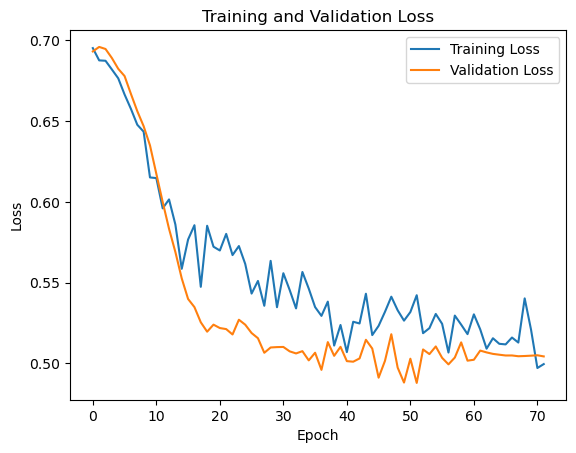

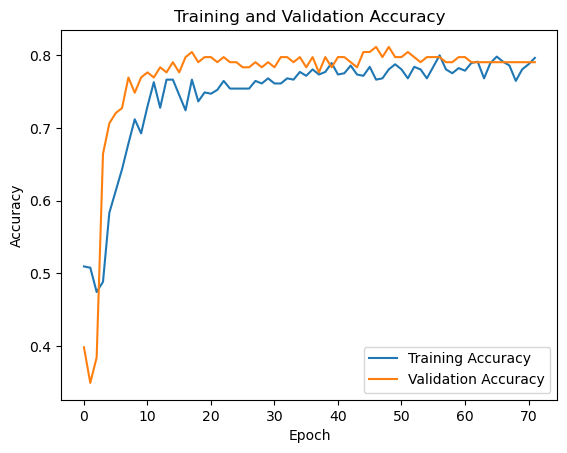

In [134]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

6/6 [==============================] - 0s 2ms/step


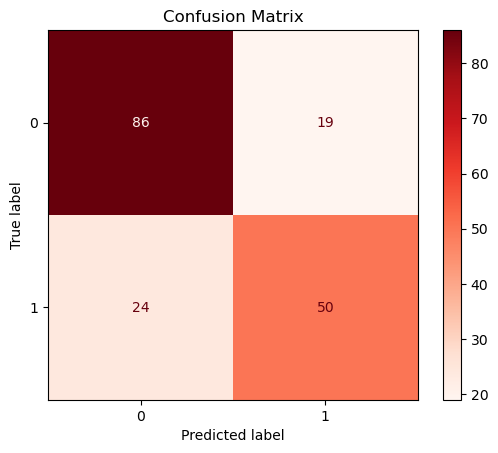

In [135]:
y_pred = model.predict(X_val)
y_pred = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.show()

# Create Submission

In [113]:
test_set_cleaned = test_set[["Pclass", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]]
test_set_cleaned = test_set_cleaned.fillna(0)
test_set_cleaned["Cabin"] = test_set_cleaned["Cabin"].astype(str)
test_set_cleaned["Embarked"] = test_set_cleaned["Embarked"].astype(str)
for column in test_set_cleaned.columns:
    encoder = LabelEncoder()
    test_set_cleaned[column] = encoder.fit_transform(test_set_cleaned[column])
for column in test_set_cleaned.columns:
    scaler = MinMaxScaler()
    reshaped_column = np.array(test_set_cleaned[column]).reshape(-1, 1)
    test_set_cleaned[column] = scaler.fit_transform(reshaped_column)

In [114]:
predictions = model.predict(test_set_cleaned)
predictions = (predictions >= 0.5).astype(int)
predictions = np.squeeze(predictions)

output = pd.DataFrame({'PassengerId': test_set["PassengerId"], 'Survived': predictions})
output.to_csv('./Data/submission.csv', index=False)

14/14 [==============================] - 0s 2ms/step
